# OpenEO endpoint in Examind - Example

By Quentin BIALOTA (Geomatys)

Contact : quentin.bialota@geomatys.com

---

### **/!\ WARNING**
This initial implementation of openEO is not yet complete and may contain bugs. Please let me know if you find any. 

For the moment we are not compatible with openEO clients. In this tutorial we will use http requests to communicate with the examind openEO implementation.

---

**Prerequisites :**
- Have an examind (via docker) running on your machine
- Have imported sentinel-2 data in Examind (through the web ui http://localhost/8080/examind [login: admin / password: admin])
- In examind, have created a WPS (in Web Services page) named `WPS` (you need to enable Versions `1.0.0` **AND** `2.0.0`)

In [1]:
# Imports (Execute this cell once)
import requests
import json
import matplotlib.pyplot as plt
import rasterio
from io import BytesIO
import os

# Set the server ip here (before the /examind), by default: localhost:8080
SERVER_IP = "http://localhost:8080"

### 1 - List openEO available processes

The first step we can do is to request the list of processes available via examind's openEO endpoint.

In [ ]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/processes"

r = requests.get(url = URL)

data = r.json()

# If you want to show the raw json output
# print(json.dumps(data, indent=2))

# Iterate over each process in the data
for process in data['processes']:
    print(f"ID: {process['id']}")

    print(f"Description: {process['description']}")

    print("Parameters:")
    for parameter in process['parameters']:
        print(f"- {parameter['name']} {parameter['schema']['type']}")
        print(f"  Description: {parameter['description']}")
        if 'subtype' in parameter['schema'] and parameter['schema']['subtype'] is not None:
            print(f"  Subtype: {parameter['schema']['subtype']}")

    print("Returns:")
    if process['returns']['schema'] is not None:
        print(f"  Description: {process['returns']['description']}")
        print(f"  Type: {process['returns']['schema']['type']}")
        if 'subtype' in process['returns']['schema'] and process['returns']['schema']['subtype'] is not None:
            print(f"  Subtype: {process['returns']['schema']['subtype']}")

    print("\n")

You can also get a list of processes that have been added by a user.

*(If you follow this tutorial in order, you shouldn't find anything for the moment.
If you come back to this request later, you'll see the process we're going to create next.)*

In [26]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/process_graphs"

r = requests.get(url = URL)

data = r.json()

# If you want to show the raw json output
# print(json.dumps(data, indent=2))

# Iterate over each process in the data
for process in data['processes']:
    print(f"ID: {process['id']}")

    print(f"Description: {process['description']}")

    print("Parameters:")
    for parameter in process['parameters']:
        print(f"- {parameter['name']} {parameter['schema']['type']}")
        print(f"  Description: {parameter['description']}")
        if 'subtype' in parameter['schema'] and parameter['schema']['subtype'] is not None:
            print(f"  Subtype: {parameter['schema']['subtype']}")

    print("Returns:")
    if process['returns']['schema'] is not None:
        print(f"  Description: {process['returns']['description']}")
        print(f"  Type: {process['returns']['schema']['type']}")
        if 'subtype' in process['returns']['schema'] and process['returns']['schema']['subtype'] is not None:
            print(f"  Subtype: {process['returns']['schema']['subtype']}")

    print("\n")

ID: examind-dynamic.openeo-evi-sentinel
Description: Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + 7.5*BLUE)`.
Parameters:
- dataId ['STRING']
  Description: Sentinel-2 data id
  Subtype: CharacterString
- bbox ['OBJECT']
  Description: Spatial extent
  Subtype: java.lang.Object
- bands ['ARRAY']
  Description: Bands to load
  Subtype: CharacterString
- temporal ['ARRAY']
  Description: Temporal extent
  Subtype: CharacterString
Returns:
  Description: Computed EVI.
  Type: ['OBJECT']




### 2 - Create your own process

This step should eventually work via openEO web Editor (https://github.com/Open-EO/openeo-web-editor), but for the moment our implementation is not compatible (nor is it compatible with openEO clients) because some of the paths to the APIs are not standard (the way the API works, however, is compliant).

For the moment, we're going to create an EVI (Enhanced Vegetation Index) process by ourselves, directly via an http request !

In [2]:
# Set Json of my EVI-Sentinel process

data = {
    'id': 'evi-sentinel',
    'summary': 'Enhanced Vegetation Index',
    'description': 'Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + 7.5*BLUE)`.',
    'parameters': [
        {
            'name': 'dataId',
            'description': 'Sentinel-2 data id',
            'schema': {
                'type': 'String'
            }
        },
        {
            'name': 'bbox',
            'description': 'Spatial extent',
            'schema': {
                'type': 'Object'
            }
        },
        {
            'name': 'temporal',
            'description': 'Temporal extent',
            'schema': {
                'type': 'Array',
                'subtype': 'String'
            }
        },
        {
            'name': 'bands',
            'description': 'Bands to load',
            'schema': {
                'type': 'Array',
                'subtype': 'String'
            }
        }
    ],
    'returns': {
        'description': 'Computed EVI.',
        'schema': {
            'type': 'object'
        }
    },
    'process_graph': {
        'load': {
            'process_id': 'examind.coverage.load',
            'arguments': {
                'coverageId': {
                    'from_parameter': 'dataId'
                },
                'spatial_extent': {
                    'from_parameter': 'bbox'
                },
                'temporal_extent': {
                    'from_parameter': 'temporal'
                },
                'bands': {
                    'from_parameter': 'bands'
                }
            }
        },
        'bs3': {
            'process_id': 'geotoolkit.coverage:bandselect',
            'arguments': {
                'coverage': {
                    'from_node': 'load'
                },
                'bands': [
                    0
                ]
            }
        },
        'bs4': {
            'process_id': 'geotoolkit.coverage:bandselect',
            'arguments': {
                'coverage': {
                    'from_node': 'load'
                },
                'bands': [
                    1
                ]
            }
        },
        'bs8': {
            'process_id': 'geotoolkit.coverage:bandselect',
            'arguments': {
                'coverage': {
                    'from_node': 'load'
                },
                'bands': [
                    2
                ]
            }
        },
        'sub': {
            'process_id': 'examind.coverage:math:substract',
            'arguments': {
                'first': {
                    'from_node': 'bs8'
                },
                'second': {
                    'from_node': 'bs3'
                }
            }
        },
        'p1': {
            'process_id': 'examind.coverage:math:multiplyWithValue',
            'arguments': {
                'value': 6.0,
                'coverage': {
                    'from_node': 'bs3'
                }
            }
        },
        'p2': {
            'process_id': 'examind.coverage:math:multiplyWithValue',
            'arguments': {
                'value': 7.5,
                'coverage': {
                    'from_node': 'bs4'
                }
            }
        },
        'sumCoverages1': {
            'process_id': 'examind.coverage:math:sum',
            'arguments': {
                'first': {
                    'from_node': 'bs8'
                },
                'second': {
                    'from_node': 'p1'
                }
            }
        },
        'sumCoverages2': {
            'process_id': 'examind.coverage:math:sum',
            'arguments': {
                'first': {
                    'from_node': 'sumCoverages1'
                },
                'second': {
                    'from_node': 'p2'
                }
            }
        },
        'sum': {
            'process_id': 'examind.coverage:math:sumWithValue',
            'arguments': {
                'coverage': {
                    'from_node': 'sumCoverages2'
                },
                'value': 1.0
            }
        },
        'div': {
            'process_id': 'examind.coverage:math:divide',
            'arguments': {
                'first': {
                    'from_node': 'sub'
                },
                'second': {
                    'from_node': 'sum'
                }
            }
        },
        'p3': {
            'process_id': 'examind.coverage:math:multiplyWithValue',
            'arguments': {
                'value': 2.5,
                'coverage': {
                    'from_node': 'div'
                }
            }
        },
        'save': {
            'process_id': 'examind.coverage.save_result',
            'arguments': {
                'format': 'GTIFF',
                'coverage': {
                    'from_node': 'p3'
                }
            },
            'result': True
        }
    }
}

You can check if your process is valid with `/validation` endpoint

In [ ]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/validation"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.post(url=URL, data=json.dumps(data), headers=headers)

print(f"Status {r.status_code}")
print(json.dumps(r.json(), indent=2))

Then, if it's valid, you can put your process on the server with `/process_graphs/{id_process}` endpoint

In [ ]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/process_graphs/evi-sentinel"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.put(url=URL, data=json.dumps(data), headers=headers)

print(f"Status {r.status_code}")
if r.text and r.text is not None:
    print(json.dumps(r.json(), indent=2))

**NOTE 1**

The process id you created is not exactly the same as the one specified. The server adds the prefix `openeo-` before your process id for internal management reasons. 
So, for example, `evi-sentinel` becomes `openeo-evi-sentinel`.

---

**NOTE 2**

If the process id already exist because you have already uploaded this process, you can delete it with the following request :

In [ ]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/process_graphs/evi-sentinel"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.delete(url=URL, headers=headers)

print(f"Status {r.status_code}")

### 3 - Execute your process (**sync way**)

You can run an openEo process in two ways :
- **synchronised** (the result arrives directly, you only have to make one request)
- **asynchronous** (you launch the process, and you have to run another request to see the status and the result).

Here, I will show you how to execute our *evi-sentinel* process with one request (sync).

We will use the `/result` endpoint

---

**NOTE**

In the case of synchronous execution, the user must create a process_graph passed in the request. A previously created process_graph cannot be queried directly. A workaround is to create a process_graph which takes only one process, the one created before (openeo-evi-sentinel).

---

**INFO**

**1. How to import my data in Examind ?**

I've written a short tutorial to import your data in Examind, using the sentinel-2 data example. Here is the link : [import_data.md](./import_data.md)

**2. How do you retrieve the id of the data you want to use ?**

I've written a short tutorial to find the data id, using the sentinel-2 data example. Here is the link : [retrieve_data_id.md](./retrieve_data_id.md)

In [2]:
# Set JSON execution process_graph

exec_data = {
    "id": "evi-execution",
    "summary": "Enhanced Vegetation Index",
    "description": "Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.",
    "parameters": [],
    "returns": {
        "description": "Computed EVI.",
        "schema": {
            "type": "object"
        }
    },
    "process_graph": {
        "load": {
            "process_id": "examind-dynamic.openeo-evi-sentinel",
            "arguments": {
                "dataId": "sentinel_b03_b04_b08:1",
                "bbox": {
                    "west": 3.87,
                    "east": 4.5,
                    "north": 43.85,
                    "south": 43.56,
                    "crs": "urn:ogc:def:crs:OGC:1.3:CRS84"
                },
                "temporal": ["none"],
                "bands": [0, 2, 4]
            },
            "result": "true"
        }
    }
}

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



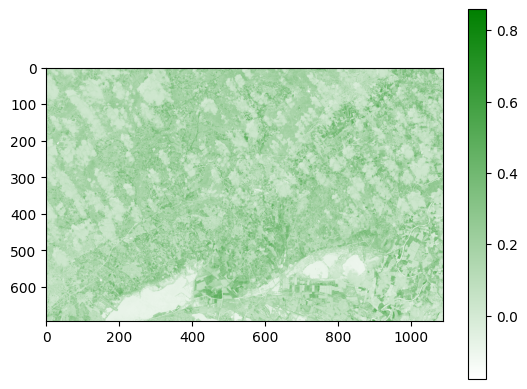

In [16]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/result"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.post(url=URL, data=json.dumps(exec_data), headers=headers)

print(f"Status {r.status_code}")
print(r.text)

file_path = "./file.tiff"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, "wb") as f:
    f.write(r.content)

with rasterio.open(BytesIO(r.content)) as src:
    image_data = src.read()
    
cmap = plt.cm.colors.LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
plt.imshow(image_data.transpose([1, 2, 0]), cmap=cmap)
plt.colorbar()
plt.show()

In [24]:
source_data_graph = {
    "id": "test-execution",
    "summary": "Enhanced Vegetation Index",
    "description": "Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.",
    "parameters": [],
    "returns": {
        "description": "Computed EVI.",
        "schema": {
            "type": "object"
        }
    },
    "process_graph": {
        "load": {
            "process_id": "examind.coverage.load",
            "arguments": {
                "coverageId": "sentinel_b03_b04_b08:1",
                "spatial_extent": {
                    "west": 3.87,
                    "east": 4.5,
                    "north": 43.85,
                    "south": 43.56
                },
                "temporal_extent": [],
                "bands": [0, 2, 4]
            },
        },
        "save": {
            "process_id": "examind.coverage.save_result",
            "arguments": {
                "format": "GTIFF",
                "coverage": {
                    "from_node": "load"
                }
            },
            "result": True
        }
    }
}

**/!\ This part doesn't work for the moment, it will be fixed soon (only one band is returned, but on the server-side we have 3 bands)**

In [ ]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/result"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.post(url=URL, data=json.dumps(source_data_graph), headers=headers)

print(f"Status {r.status_code}")
print(r.text)

file_path = "./source.tiff"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, "wb") as f:
    f.write(r.content)

with rasterio.open(BytesIO(r.content)) as src:
    image_data = src.read()

plt.imshow(image_data.transpose([1, 2, 0]), cmap=cmap)
plt.colorbar()
plt.show()

### 4 - Execute your process (**async way**)

Here, I will show you how to execute our *evi-sentinel* process the async way.

- We will use the `/jobs` endpoint to create process job and get all jobs created *(4.1 & 4.2)*
- We will use the `/jobs/{job_id}/results` to execute a job and get its results *(4.3 & 4.4)*
- We will use the `/jobs/{job_id}` to delete a job *(4.5)*

#### 4.1 - Create a process job
`POST` - `/jobs`

In [52]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/jobs"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.post(url=URL, data=json.dumps(exec_data), headers=headers)

print(f"Status {r.status_code}")
if r.text and r.text is not None:
    if r.status_code == 200 or r.status_code == 201:
        print(f"Job ID : {r.text}")
        JOB_ID = r.text
    else:
        print(r.text)

Status 201
Job ID : f3cf562a-6ee0-438b-bd9f-35a6b0fab523


In [ ]:
# If you want to set another JOB_ID :
JOB_ID = "<job_id>"

#### 4.2 - Get jobs created and status
`GET` - `/jobs`

In [53]:
URL = SERVER_IP + "/examind/WS/openeo/process/WPS/jobs"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.get(url=URL, headers=headers)

print(f"Status {r.status_code}")
if r.text and r.text is not None:
    print(json.dumps(r.json(), indent=2))

Status 200
{
  "jobs": [
    {
      "id": "f3cf562a-6ee0-438b-bd9f-35a6b0fab523",
      "status": "created",
      "created": "2024-09-20T09:54:13",
      "progress": 0.0,
      "costs": 0.0,
      "budget": 0.0
    }
  ],
  "links": []
}


#### 4.3 - Run a job
`POST` - `/jobs/{job_id}/results`

In [54]:
URL = SERVER_IP + f"/examind/WS/openeo/process/WPS/jobs/{JOB_ID}/results"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.post(url=URL, headers=headers)

print(f"Status {r.status_code}")
if r.text and r.text is not None:
    print(r.text)

Status 202
created


#### 4.4 - Get job result
`GET` - `/jobs/{job_id}/results`

Status 200


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



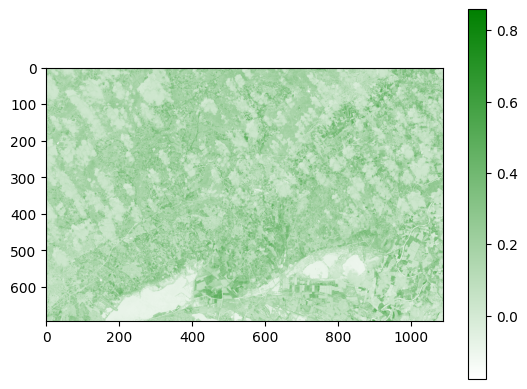

In [59]:
URL = SERVER_IP + f"/examind/WS/openeo/process/WPS/jobs/{JOB_ID}/results"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.get(url=URL, headers=headers)

print(f"Status {r.status_code}")
if r.text and r.text is not None:
    print(r.text)

with rasterio.open(BytesIO(r.content)) as src:
    image_data = src.read()

cmap = plt.cm.colors.LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
plt.imshow(image_data.transpose([1, 2, 0]), cmap=cmap)
plt.colorbar()
plt.show()

#### 4.5 - Delete job
`DELETE` - `/jobs/{job_id}`

In [60]:
# For this request, you need to be authenticated !
URL = SERVER_IP + f"/examind/API/auth/login"
body = {"username":"admin","password":"admin"}

r = requests.post(url=URL, data=json.dumps(body), headers=headers)

##################################################

URL = SERVER_IP + f"/examind/WS/openeo/process/WPS/jobs/{JOB_ID}"

headers = {'Content-Type': 'application/json', 'Accept': '*/*'}

r = requests.delete(url=URL, headers=headers, cookies=r.cookies)

print(f"Status {r.status_code}")
if r.text and r.text is not None:
    print(r.text)

Status 200
